# Albedo Test Data Creation
This notebook creates clipped IMS, MODIS, and composite albedo data to use for testing. Selecting appropriate extents to clip to is slightly tricky as the IMS data is in a polar projection and does not always clip cleanly to a perfect rectangle.

In [1]:
import sys
import os
from datetime import datetime as dt
nsrdb_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
if nsrdb_path not in sys.path:
    print('Adding nsrdb to path')
    sys.path.append(nsrdb_path)

import nsrdb.albedo.ims as ims
import nsrdb.albedo.modis as modis
import nsrdb.albedo.albedo as albedo

import matplotlib.pyplot as plt
import numpy as np
import importlib
from pyhdf.SD import SD, SDC, HDF4Error 

importlib.reload(ims)
importlib.reload(modis)

Adding nsrdb to path


<module 'nsrdb.albedo.modis' from '/Users/mbannist/projects/nsrdb/code/nsrdb/albedo/modis.py'>

In [2]:
# Resolution to create test data for. ['1km', '4km']
res = '1km'
# res = '4km'

# Extents have been carefully choosen to form perfect rectangles. This is somewhat challenging
# as the IMS data is in a polar projection
if res == '4km':
    # 4km day
    d = dt(2013, 1,1)
    lat_min = 38 
    lat_max = 39.02  
    lon_min = -80
    lon_max = -79
    # Number of rows and columns in clipped IMS data, MODIS is determined auotmatically. 
    # TODO Determine this automatically, otherwise count by hand from scatter plot below
    rows = 32
    cols = 25
else:
    # 1km day
    d = ims.get_dt(2015, 1)
    lat_min = 38 
    lat_max = 38.5  
    lon_min = -80.2
    lon_max = -79.7
    # Number of rows and columns in clipped IMS data, MODIS is determined auotmatically. 
    rows = 64
    cols = 50

# Path for real data
data_path = '.'

# Path for clipped test data
test_data_path = './test_data'


## Create IMS test data

In [3]:
i = ims.ImsDay(d, data_path)
#%matplotlib qt
#plt.imshow(i.data ) 
#plt.colorbar()
#plt.show()

ims2015002_1km_v1.3.asc found on disk at .
IMS metadata found on disk at .
Loading IMS data
Loading IMS metadata
Completed loading IMS data and metadata


Raw clipped data shape is: (3200,)


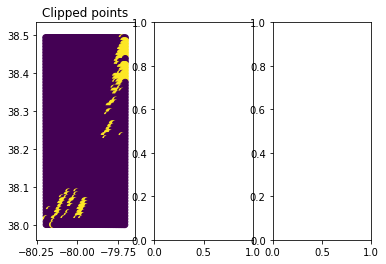

In [4]:
%matplotlib qt
lat_msk =(lat_min <= i.lat) & (i.lat <= lat_max)
lon_msk =(lon_min <= i.lon) & (i.lon <= lon_max)
mask = lat_msk & lon_msk
data_mskd = i.data.flatten()[mask]
data_new = data_mskd.reshape((rows, cols))
# Row order for IMS asc data is reversed, with "top" rows at bottom of file
data_new_flipped = np.flipud(data_new)

lat_mskd = i.lat[mask]
lon_mskd = i.lon[mask]

print('Raw clipped data shape is:', data_mskd.shape)
#plt.style.use('ggplot')
#plt.scatter(lon_mskd, lat_mskd, c = data_mskd)
##for j, txt in enumerate(data_mskd):
#    #plt.annotate(j, (lon_mskd[j], lat_mskd[j]))
#plt.show()

fig, axes = plt.subplots(1,3)
axes[0].scatter(lon_mskd, lat_mskd, c = data_mskd)
#for j, txt in enumerate(data_mskd):
    #ax.annotate(j, (lon_mskd[j], lat_mskd[j]))
axes[0].set_title( 'Clipped points')
plt.show()

axes[1].imshow(data_new)
axes[1].set_title('Clipped data reshaped to grid')

axes[2].imshow(data_new_flipped)
axes[2].set_title('Clipped data reshaped and flipped')
fig.suptitle('Please verify all results look correct')
plt.show()

## Write test IMS data to disk

In [5]:
meta_header = '''Total # scientific data sets: 1
File description:
This file contains Northern Hemisphere snow and ice coverage produced by the NOAA/NESDIS Interactive Multisensor Snow and Ice Mapping System (IMS) developed under the direction of the NOAA Ice Center (NIC) For more information please contact Mr. Sean Helfrich at sean.helfrich@noaa.gov
<lines removed>
   Dimension #       1
     Dim Label:                         Latitude
     Dim Format:                        Device Coordinates
     Dim Units:                         Pixels
'''
# print(data_mskd)

# Write masked IMS data to disk
ifa = ims.ImsFileAcquisition(d, data_path)
filename = os.path.join(test_data_path, os.path.split(ifa.filename)[1])
with open(filename, 'wt') as f:
    f.write(meta_header)
    # write each row of data as a string
    for r in data_new_flipped:
        txt = ''.join(r.astype(str))
        # print(txt)
        f.write(txt)
        f.write('\n')
    
# Write meta data to disk
lat_file = os.path.join(test_data_path, os.path.split(ifa.lat_file)[1])
lon_file = os.path.join(test_data_path, os.path.split(ifa.lon_file)[1])

# 1km meta data is stored as double, 4km as float32
if i.res == '1km':
    lat_mskd.astype(np.double).tofile(lat_file)
    lon_mskd.astype(np.double).tofile(lon_file)
else:
    lat_mskd.tofile(lat_file)
    lon_mskd.tofile(lon_file)
print('Done!')

Done!


## Reload IMS test data from disk and compare to original 

In [6]:
%matplotlib qt
importlib.reload(ims)
it = ims.ImsDay(d, test_data_path, shape=(rows, cols))

fig, axes = plt.subplots(1,3)
axes[0].scatter(lon_mskd, lat_mskd, c=data_mskd)
axes[0].set_title('Clipped test data')
axes[1].scatter(it.lon, it.lat, c=it.data.flatten())
axes[1].set_title('Test data from disk')
axes[2].imshow(it.data)
#axes[1].scatter(it.lon, it.lat, c=it.data.flatten())
axes[2].set_title('Test data from disk')
fig.suptitle('Both data sets should match. Please check!')
plt.show()

if np.array_equal(data_new, it.data) and \
   np.array_equal(lon_mskd, it.lon) and \
   np.array_equal(lat_mskd, it.lat):
    print('Test data read from disk matches original clipped data')
else:
    raise ValueError('Test data on disk does not match clipped data!')

ims2015002_1km_v1.3.asc found on disk at ./test_data
IMS metadata found on disk at ./test_data
Loading IMS data
Loading IMS metadata
Completed loading IMS data and metadata
Test data read from disk matches original clipped data


# Create MODIS test data

In [7]:
importlib.reload(modis) 
m = modis.ModisDay(d, data_path)
lat_msk = (lat_min <= m.lat ) & (m.lat <= lat_max)
lat_mskd = m.lat[lat_msk]
lon_msk = (lon_min <= m.lon ) & (m.lon <= lon_max)
lon_mskd = m.lon[lon_msk]
data_mskd=m.data[np.ix_(lat_msk, lon_msk)] 
m_shape = data_mskd.shape
print(f'MODIS test date shape: {m_shape}')

# Create data data hdf file
filename = os.path.join(test_data_path, os.path.split(m._filename)[1])
try:
    os.remove(filename)
except Exception as e:
    print(e)
    
try:
    hdf = SD(filename, SDC.WRITE | SDC.CREATE)
    sds = hdf.create('Albedo_Map_0.3-5.0', SDC.INT16, data_mskd.shape)
    sds[:] = data_mskd
    sds.endaccess()
    sd_lat = hdf.create('Latitude', SDC.FLOAT32, lat_mskd.shape)
    sd_lat[:] = lat_mskd
    sd_lat.endaccess()
    sd_lon = hdf.create('Longitude', SDC.FLOAT32, lon_mskd.shape)
    sd_lon[:] = lon_mskd
    sd_lon.endaccess()
    hdf.end()
except HDF4Error as e:
    raise("HDF Error", e)
print('Done!!')

MCD43GF_wsa_shortwave_001_2015.hdf found on disk at .
Loading MODIS data
Loading MODIS metadata
Completed loading MODIS data and metadata
MODIS test date shape: (60, 61)
Done!!


In [8]:
%matplotlib qt
# Compare test data saved to disk to data just clipped 
mt = modis.ModisDay(d, test_data_path, shape=m_shape)

fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(data_mskd)
axes[0].set_title('Clipped test data')

axes[1].imshow(mt.data)
axes[1].set_title('Test data from disk')
plt.show()

if np.array_equal(data_mskd, mt.data):
    print ('Data sets are the same')
else:
    raise ('Test data on disk does not match clipped data')

MCD43GF_wsa_shortwave_001_2015.hdf found on disk at ./test_data
Loading MODIS data
Loading MODIS metadata
Completed loading MODIS data and metadata
Data sets are the same


## Create composite albedo test data and plot to test

In [9]:
%matplotlib qt
importlib.reload(albedo)
importlib.reload(modis)
cad = albedo.CompositeAlbedoDay.run(d, test_data_path, test_data_path, test_data_path, 
                                   ims_shape=(rows, cols), modis_shape=m_shape)
cad.write_albedo()

fig, axes = plt.subplots(1,3)
im0 = axes[0].imshow(it.data)
axes[0].set_title(f'IMS-lat({min(cad.ims.lat)}, {max(cad.ims.lat)})\n' + 
                    f'lon({min(cad.ims.lon)}, {max(cad.ims.lon)})\n' +
                    f'Shape: {cad.ims.data.shape}')
fig.colorbar(im0, ax = axes[0])

im1 = axes[1].imshow(mt.data, vmin=0, vmax=870)
axes[1].set_title(f'MODIS-lat({min(cad.modis.lat)}, {max(cad.modis.lat)})\n' + 
                    f'lon({min(cad.modis.lon)}, {max(cad.modis.lon)})\n' + 
                    f'Shape: {cad.modis.data.shape}')
fig.colorbar(im1, ax = axes[1])

im2 = axes[2].imshow(cad.albedo, vmin=0, vmax=870)
axes[2].set_title(f'Composite albedo')
fig.colorbar(im2, ax = axes[2])
fig.suptitle(f'{d}, IMS res: {res}')
plt.show()

Loading MODIS data for 2015-01-01 00:00:00
MCD43GF_wsa_shortwave_001_2015.hdf found on disk at ./test_data
Loading MODIS data
Loading MODIS metadata
Completed loading MODIS data and metadata
Loading IMS data 2015-01-01 00:00:00
ims2015002_1km_v1.3.asc found on disk at ./test_data
IMS metadata found on disk at ./test_data
Loading IMS data
Loading IMS metadata
Completed loading IMS data and metadata
Calculating composite albedo for 2015-01-01 00:00:00
Determining IMS snow/no snow region boundaries
Creating KD Tree
Mapping MODIS to IMS data. This might take a while.
Started all futures
1 out of 16 futures completed.
2 out of 16 futures completed.
3 out of 16 futures completed.
4 out of 16 futures completed.
5 out of 16 futures completed.
6 out of 16 futures completed.
7 out of 16 futures completed.
8 out of 16 futures completed.
9 out of 16 futures completed.
10 out of 16 futures completed.
11 out of 16 futures completed.
12 out of 16 futures completed.
13 out of 16 futures completed.
14 

## Scratch
